### Solar System Object Colors ###

This functions as a demo notebook of how to calculate colors of objects (in general),
but is specifically targeted and extended toward solar system objects. 

Solar system objects usually have reported reflectance spectra, rather than the
'as-observed' spectra. 

This notebook calculates synthetic colors for a sample of SMASSII reflectance spectra, and compares the results in LSST colors compared to SDSS colors. The results suggest that classification based on SDSS colors should work well in LSST, although the g band filter is likely not quite as optimal as SDSS (pending delivered filter curves). For objects bright enough to be visible in y band, the results may be even better as we will be able to prove new wavelength ranges. 

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import colorcet
import cycler
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
import rubin_sim.phot_utils as phot_utils
from rubin_sim.data import get_data_dir

For a starting point, let's demonstrate going from a reflectance spectra to an observed SED, and then observed colors (in LSST and/or other systems) using rubin_sim. 

In [2]:
# We have some sample asteroid spectra in rubin_sim_data_dir - this is what 'get_data_dir' returns.
# However, those are 'observed' spectra (already includes a sample solar spectra)
ast_templates = [k.replace('.dat.gz', '') for k in os.listdir(os.path.join(get_data_dir(), 'movingObjects')) 
                 if 'kurucz' not in k and 'harris' not in k]

In [3]:
# Read the sso seds from disk (using rubin_sim.photUtils.Sed)
sso = {}
for k in ast_templates:
    sso[k]= phot_utils.Sed()
    sso[k].read_sed_flambda(os.path.join(get_data_dir(), 'movingObjects', f'{k}.dat.gz'))

# Read the sun too
sun = phot_utils.Sed()
sun.read_sed_flambda(os.path.join(get_data_dir(), 'movingObjects', 'kurucz_sun.gz'))

Text(0, 0.5, 'F_lambda  (ergs/cm^s/s/nm)')

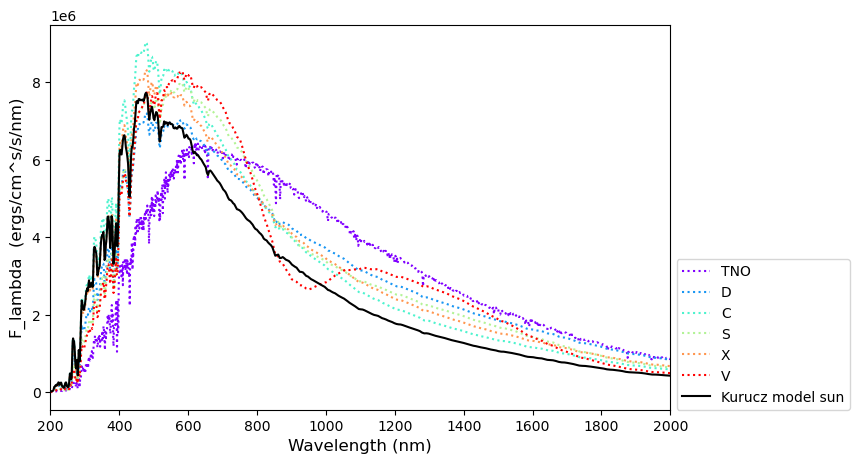

In [4]:
# Let's visualize, with maybe a better way of cycling through the colors for the linestyles

fig = plt.figure(figsize=(8, 5))
ax = plt.gca()

# Pick a subset to plot to make it less confusing
subset = ['TNO', 'D', 'C', 'S', 'X', 'V']
color = cm.rainbow(np.linspace(0, 1, len(subset)))
ax.set_prop_cycle(cycler.cycler('color', color))

# Normalize the SEDs so they fit on the same plot but still make a bit more sense
# This particular normalization essentially makes all of the objects (and the sun) have
# the same total flux over the wwavelen_min to wwavelen_max window
wwavelen_min = 200
wwavelen_max = 2000
sun_window = np.where((sun.wavelen > wwavelen_min) & (sun.wavelen < wwavelen_max))
sun_max = sun.flambda[sun_window].mean()

for k in subset:
    sso_window = np.where((sso[k].wavelen > wwavelen_min) & (sso[k].wavelen < wwavelen_max))
    norm = sun_max / (sso[k].flambda[sso_window].mean())
    plt.plot(sso[k].wavelen, sso[k].flambda * norm, label=k, linestyle=':')
plt.plot(sun.wavelen, sun.flambda, 'k',  linestyle='-', label='Kurucz model sun')
plt.legend(loc=(1.01, 0.0))
plt.xlim(200, 2000)
plt.xlabel('Wavelength (nm)', fontsize='large')
plt.ylabel('F_lambda  (ergs/cm^s/s/nm)', fontsize='large')

With these 'observed' spectra, it's pretty straight forward to calculate expected magnitudes in the LSST bandpasses.

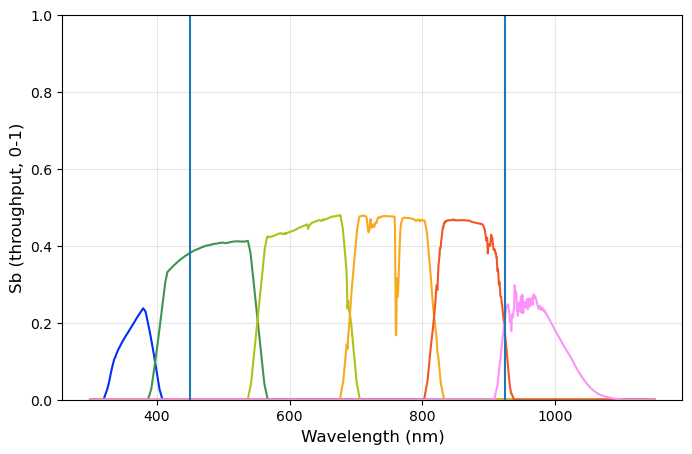

In [5]:
# Read in the lsst total system bandpasses (this is QE, filters, telescope and sample atmosphere)
lsst = {}
lsst_filterlist = 'ugrizy'
for f in lsst_filterlist:
    lsst[f] = phot_utils.Bandpass()
    lsst[f].read_throughput(os.path.join(get_data_dir(), 'throughputs', 'baseline', f'total_{f}.dat'))

cmap = colorcet.cm['CET_R1'](np.linspace(0, 1, len(lsst_filterlist)))

fig = plt.figure(figsize=(8,5))
for i, f in enumerate(lsst_filterlist):
    plt.plot(lsst[f].wavelen, lsst[f].sb, color=cmap[i])
plt.xlabel('Wavelength (nm)', fontsize='large')
plt.ylabel('Sb (throughput, 0-1)', fontsize='large')
plt.grid(alpha=0.3)
plt.ylim(0, 1)
plt.axvline(450)
plt.axvline(925)

In [6]:
# Note that we can also read in other bandpasses from the throughputs directory -- 
os.listdir(os.path.join(get_data_dir(), 'throughputs'))

['sdss',
 'megacam',
 'imsim',
 'baseline',
 'panStarrs',
 'atmos',
 'README.md',
 '2MASS',
 'tycho',
 'WISE',
 'approximate_baseline',
 'johnson',
 'hipparcos']

(0.0, 1.0)

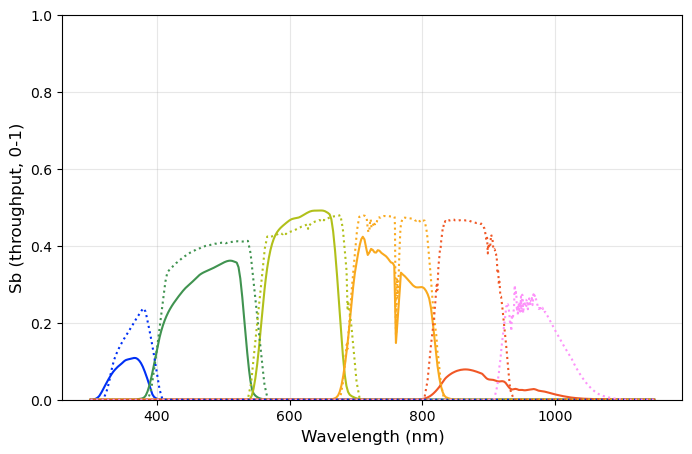

In [7]:
# Read in the sdss total system bandpasses (this is QE, filters, telescope and sample atmosphere, again)
sdss = {}
sdss_filterlist = 'ugriz'
for f in sdss_filterlist:
    sdss[f] = phot_utils.Bandpass()
    sdss[f].read_throughput(os.path.join(get_data_dir(), 'throughputs', 'sdss', f'sdss_{f}.dat'))

cmap = colorcet.cm['CET_R1'](np.linspace(0, 1, len(lsst_filterlist)))

fig = plt.figure(figsize=(8,5))
for i, f in enumerate(sdss_filterlist):
    plt.plot(sdss[f].wavelen, sdss[f].sb, color=cmap[i])
for i, f in enumerate(lsst_filterlist):
    plt.plot(lsst[f].wavelen, lsst[f].sb, linestyle=':', color=cmap[i])
plt.xlabel('Wavelength (nm)', fontsize='large')
plt.ylabel('Sb (throughput, 0-1)', fontsize='large')
plt.grid(alpha=0.3)
plt.ylim(0, 1)

Calculating magnitudes in each of these bandpasses. 

Note that really we're looking for colors, so the overall normalization of the fluxes for each object (or the magnitudes in any given band) are not important; just the relative differences of the magnitudes. We'll use 'lsst r' as the reference for now. 

In [8]:
refband_name = 'r'
refband = lsst[refband_name]

# Calculate the reference bandpass magnitudes
refmags = {}
for k in sso:
    refmags[k] = sso[k].calc_mag(refband)

# Calculate the colors
colors = {}
for k in sso:
    colors[k] = {}
    for f in lsst_filterlist:
        colors[k][f'lsst_{f}'] = sso[k].calc_mag(lsst[f]) - refmags[k]
        
        
# Let's calculate colors for SDSS -- but let's update refband so we're using sdss r 
refband = sdss[refband_name]

# Calculate the reference bandpass magnitudes
refmags = {}
for k in sso:
    refmags[k] = sso[k].calc_mag(refband)

# Calculate the colors
for k in sso:
    for f in sdss_filterlist:
        colors[k][f'sdss_{f}'] = sso[k].calc_mag(sdss[f]) - refmags[k]

In [9]:
df_colors = pd.DataFrame(colors)
df_colors

,D,R,TNO,Cg,Sv,B,V,Sr,Cgh,L,...,Ch,K,Xk,S,Cb,Xc,O,C,A,Sq
lsst_u,1.904652,2.206750,2.548508,1.931740,2.070095,1.688083,2.233633,2.179799,1.917585,2.105767,...,1.736446,1.977124,1.802801,2.129080,1.598896,1.806788,1.886488,1.723571,2.530651,2.107818
lsst_g,0.577264,0.693363,0.915011,0.541108,0.645732,0.460440,0.695886,0.655136,0.516036,0.653234,...,0.456163,0.592332,0.521171,0.654205,0.436608,0.516802,0.532195,0.476202,0.794241,0.637479
lsst_r,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lsst_i,-0.211503,-0.172324,-0.381887,-0.109209,-0.224038,-0.087457,-0.152789,-0.174388,-0.106343,-0.205424,...,-0.101523,-0.168721,-0.150836,-0.192314,-0.123852,-0.152902,-0.084650,-0.114002,-0.218935,-0.163748
lsst_z,-0.298785,0.031676,-0.588997,-0.106706,-0.160094,-0.063236,0.167049,-0.071307,-0.136510,-0.221906,...,-0.125378,-0.145809,-0.170075,-0.135177,-0.144257,-0.183496,0.147843,-0.119666,-0.138150,-0.078562
lsst_y,-0.389105,0.055530,-0.699987,-0.112148,-0.195119,-0.044676,0.152775,-0.086032,-0.166098,-0.245780,...,-0.145141,-0.132430,-0.204687,-0.144213,-0.160145,-0.205868,0.291362,-0.124417,-0.044370,-0.052835
sdss_u,2.024160,2.348615,2.701873,2.068506,2.199047,1.803102,2.380326,2.328208,2.058616,2.240857,...,1.859988,2.106106,1.920398,2.268211,1.703995,1.925979,2.016140,1.839828,2.707846,2.248214
sdss_g,0.616040,0.740380,0.975935,0.584442,0.687729,0.496791,0.743471,0.701442,0.559530,0.697735,...,0.493954,0.634196,0.558659,0.699476,0.468696,0.554317,0.573048,0.512695,0.849171,0.682735
sdss_r,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sdss_i,-0.214031,-0.183585,-0.384183,-0.110768,-0.230502,-0.089177,-0.165173,-0.181286,-0.106134,-0.210372,...,-0.101440,-0.173147,-0.153275,-0.198426,-0.125105,-0.154902,-0.091638,-0.115552,-0.229485,-0.170191


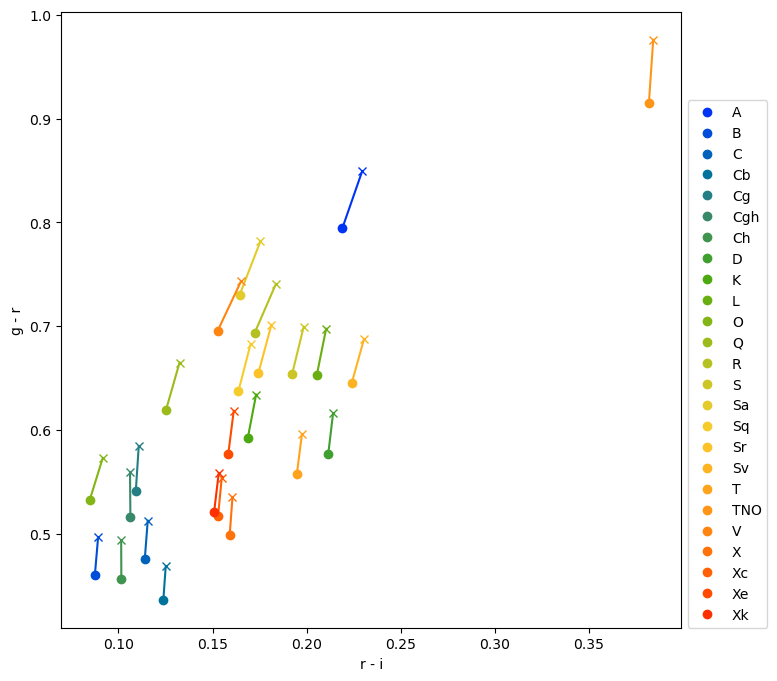

In [10]:
# Plot some color-color combinations
c1 = 'lsst_g'  #g-r
cc1 = 'sdss_g'
c2 = 'lsst_i'  #i-r .. we'll flip so it's r-i
cc2 = 'sdss_i'

fig = plt.figure(figsize=(8,8)) 
cmap = colorcet.cm['CET_R2'](np.linspace(0, 1, len(sso)))

sso_keys = sorted(list(sso.keys()))
for i, k in enumerate(sso_keys):
    c = cmap[i]
    plt.plot(-colors[k][c2], colors[k][c1], linestyle='', marker='o', color=c, label=k)
    plt.plot(-colors[k][cc2], colors[k][cc1], linestyle='', marker='x', color=c)
    plt.plot([-colors[k][c2], -colors[k][cc2]],
            [colors[k][c1], colors[k][cc1]], linestyle='-', marker='', color=c)
plt.xlabel(f"{refband_name} - {c2.replace('lsst_', '')}")
plt.ylabel(f"{c1.replace('lsst_', '')} - {refband_name}")
plt.legend(loc=(1.01, 0.0))

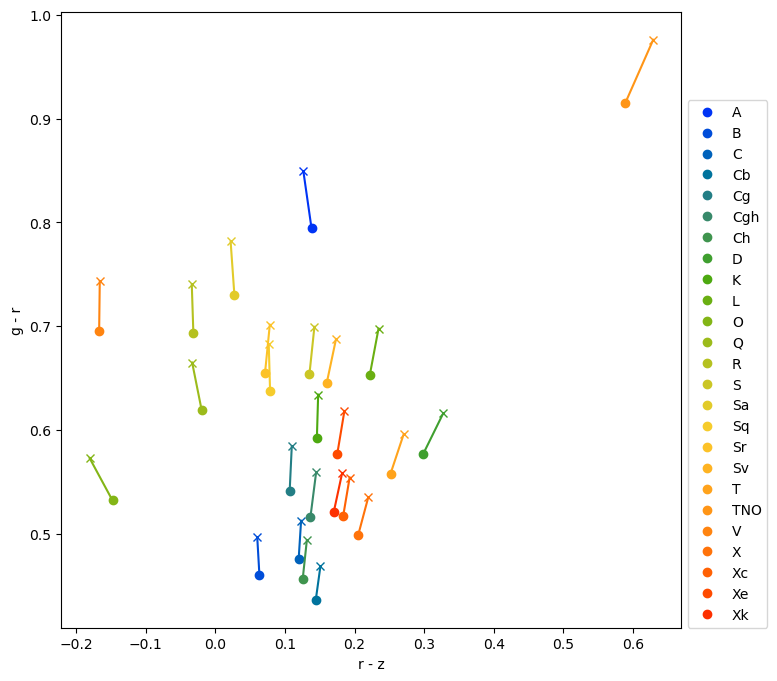

In [11]:
# Plot some color-color combinations
c1 = 'lsst_g'  #g-r
cc1 = 'sdss_g'
c2 = 'lsst_z'  #z-r .. we'll flip so it's r-z
cc2 = 'sdss_z'

fig = plt.figure(figsize=(8,8)) 
cmap = colorcet.cm['CET_R2'](np.linspace(0, 1, len(sso)))

sso_keys = sorted(list(sso.keys()))
for i, k in enumerate(sso_keys):
    c = cmap[i]
    plt.plot(-colors[k][c2], colors[k][c1], linestyle='', marker='o', color=c, label=k)
    plt.plot(-colors[k][cc2], colors[k][cc1], linestyle='', marker='x', color=c)
    plt.plot([-colors[k][c2], -colors[k][cc2]],
            [colors[k][c1], colors[k][cc1]], linestyle='-', marker='', color=c)
plt.xlabel(f"{refband_name} - {c2.replace('lsst_', '')}")
plt.ylabel(f"{c1.replace('lsst_', '')} - {refband_name}")
plt.legend(loc=(1.01, 0.0))

So that's interesting and I'm not sure I quite understand what's going on. It's likely understandable that $z$ band colors change, as the $z$ bands in LSST are fairly different from SDSS. But this seems to show a big change in g-r colors as well, which I wasn't expecting. Could it be due to the slightly wider gap between g and r in SDSS? (this seems possible; it's a wavelength range where the asteroid observed SEDs are changing strongly due to the slope of the Sun's SED). 

Anyway .. let's see if we get any further insights after loading up a range of reflectance spectra (which we can also demonstrate turning into the SEDs we use to calculate photometry).

I downloaded the set of reflectance spectra from SMASS2 (Bus & Binzel), let's see what we can get.
http://smass.mit.edu/smass.html

https://sbn.psi.edu/pds/resource/smass2.html

citation: "Bus, S. and Binzel, R. P. (2020) Small Main-belt Asteroid Spectroscopic Survey, Phase II V1.0. urn:nasa:pds:gbo.ast.smass2.spectra::1.0. NASA Planetary Data System; https://doi.org/10.26033/fj1d-vb37." 

In [12]:
# grab from https://sbnarchive.psi.edu/pds4/non_mission/gbo.ast.smass2.spectra.zip
ddir = 'gbo.ast.smass2.spectra/data'

obj_files = glob.glob(f'{ddir}/data*/*.tab')
test_file = obj_files[8]
print(len(obj_files), test_file)

1341 gbo.ast.smass2.spectra/data/data10/24_00.tab


In [13]:
##### The SMASS2 data covers 435 - 925 nm. This means r, i, z band are relatively well covered,
# but only ~half of g band is inside this wavelength range. We'll extrapolate at least to cover g.
# I also extrapolated over u and y band, but these are probably really unreliable.

def extend_smass(filename):
    tt = pd.read_table(test_file, delim_whitespace=True, names=['wavelen', 'reflectance', 'reflectance_error'])
    # A few files have extraneous wavelength = 0 entries so let's remove those
    tt.query('wavelen > 0', inplace=True)
    tt.wavelen = tt.wavelen * 1000 # convert to nm
    # Get a smoothed version
    # The spectra are typically constant wavelength spacing within some range, then a jump, then constant spacing
    # Seems like this occurs around ~515 and ~750 nm (instrument configuration changes?)
    # window length * 2.5nm = wavelength range (35 ~ 87nm )
    sf = signal.savgol_filter(tt.reflectance,
                                    window_length=35, 
                                    polyorder=3)

    sf2 = signal.savgol_filter(tt.reflectance,
                                window_length=35, 
                                polyorder=1)

    tt['smoothed_reflectance'] = np.where(tt.reflectance_error > 0.03 * tt.reflectance, sf2, sf)
    
    # Note that all of these SEDs only reaches from 425 to 925 nm, cutting off at the red end of z band 
    # and midway through the g band, also missing all of the u and y bands (so those colors will not be reliable)

    # Fit the slope for the blue end and try to extend it 
    bluest = tt.wavelen.min()
    condition = ((tt.wavelen>bluest) & (tt.wavelen<bluest+100))    
    wavelen_extend = np.arange(300, bluest+0.5, 1)
    interp = interp1d(tt.wavelen[condition], tt.smoothed_reflectance[condition], 
                      kind='slinear', fill_value='extrapolate')
    reflect_extend = interp(wavelen_extend)

    wavelen_final = np.concatenate((wavelen_extend, tt.wavelen.values))
    reflect_final = np.concatenate((reflect_extend, tt.smoothed_reflectance.values))
    
    # After some attempts to extend the red end .. I think this needs something 
    # better than a simple extrapolation, due to various actual bumps in the spectra that 
    # happen near 900 nm. But we can give it a go and remember y band is probably wrong.
    condition = ((tt.wavelen>850) & (tt.wavelen < 925))
    wavelen_extend = np.arange(tt.wavelen.max(), 1103, 1)
    interp = interp1d(tt.wavelen[condition], tt.smoothed_reflectance[condition],
                      kind='slinear', fill_value='extrapolate')
    reflect_extend = interp(wavelen_extend)
    wavelen_final = np.concatenate([wavelen_final, wavelen_extend])
    reflect_final=np.concatenate([reflect_final, reflect_extend])
    
    
    ast_sed = phot_utils.Sed()
    ast_sed.set_sed(wavelen=wavelen_final, flambda=reflect_final)

    return ast_sed

In [14]:
# Read the files and add the extrapolations
smass = {}
names = []
for test_file in obj_files: #['a000391.spfit', 'a005379.spfit', 'a002579.spfit']:
    name = os.path.split(test_file)[-1].split('_')[0]
    if name in names:
        print(name)
    names.append(name)
    smass[name] = extend_smass(test_file)

Text(0.5, 1.0, 'SMASS II')

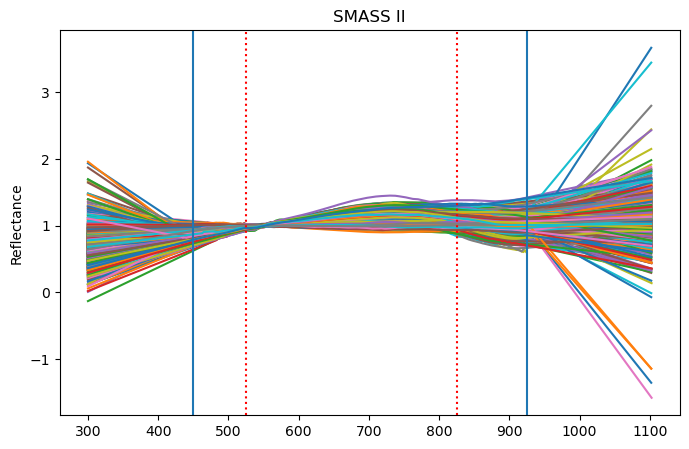

In [15]:
plt.figure(figsize=(8, 5))
for k in smass:
    plt.plot(smass[k].wavelen, smass[k].flambda)
plt.axvline(925)
plt.axvline(825, color='r', linestyle=':')
plt.axvline(450)
plt.axvline(525, color='r', linestyle=':')
plt.title('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('SMASS II')

Well -- anyway, that's probably close enough. 
Let's go ahead and turn them into SEDs we can use for calculating observed magnitudes. 

In [16]:
# Limit the wavelength range for the sun, just to reduce warning messages
sun_limited = phot_utils.Sed()
idx = np.where((sun.wavelen > 299) & (sun.wavelen < 1105))
sun_limited.set_sed(wavelen=sun.wavelen[idx], flambda=sun.flambda[idx])
obs_smass = {}
for k in smass:
    obs_smass[k] = smass[k].multiply_sed(sun_limited)

/Users/yoachim/git_repos/rubin_sim/rubin_sim/phot_utils/sed.py:869: UserWarning: There is an area of non-overlap between desired wavelength range  (300.00 to 1101.00)and sed FromArray (299.89 to 1100.95)
  warnings.warn(


Text(0, 0.5, 'Flambda')

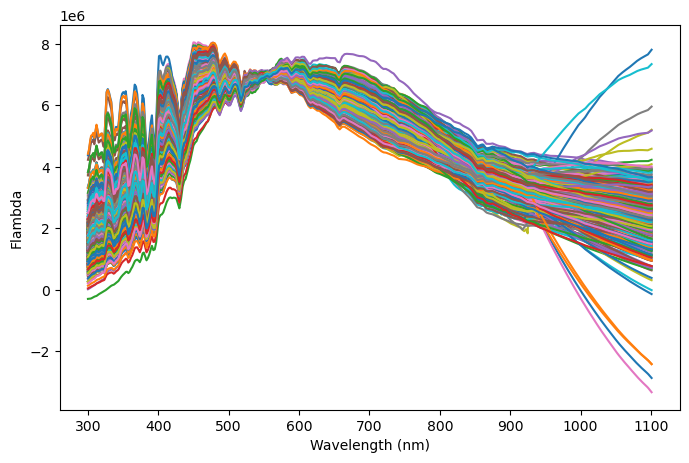

In [17]:
plt.figure(figsize=(8, 5))
for k in smass:
    plt.plot(obs_smass[k].wavelen, obs_smass[k].flambda)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flambda')

In [18]:
# Okay - so maybe this is kind of dumb, but because the filters have a wavelength grid that extends 
# farther than the smass asteroids are defined, there will be errors. 
# We can avoid this by either extending the information for the SEDs down to the end of the filter throughputs,
# or just read the throughputs again and cut off at 925. 
# Because of issues when we were generating catalogs for imsim, the error behavior results in Nans in the magnitudes,
# instead of substituting zero flux. (I have an idea for an update, but will have to look later)

# The easiest way around this, particularly because we know the seds are unreliable beyond 925, is to read 
# in the filters again and cut off at higher wavelength.

lsst = {}
lsst_filterlist = 'ugrizy'
for f in lsst_filterlist:
    lsst[f] = phot_utils.Bandpass()
    lsst[f].read_throughput(os.path.join(get_data_dir(), 'throughputs', 'baseline', f'total_{f}.dat'),
                          wavelen_min=300, wavelen_max=1100)
sdss = {}
sdss_filterlist = 'ugriz'
for f in sdss_filterlist:
    sdss[f] = phot_utils.Bandpass()
    sdss[f].read_throughput(os.path.join(get_data_dir(), 'throughputs', 'sdss', f'sdss_{f}.dat'),
                          wavelen_min=300, wavelen_max=1100)

In [19]:
# And now we can calculate colors again - 
refband_name = 'r'
refband = lsst[refband_name]

# Calculate the reference bandpass magnitudes
refmags = {}
for k in smass:
    refmags[k] = smass[k].calc_mag(refband)

# Calculate the colors
colors = {}
for k in smass:
    colors[k] = {}
    for f in 'ugriz':
        colors[k][f'lsst_{f}'] = smass[k].calc_mag(lsst[f]) - refmags[k]
        
        
# Let's calculate colors for SDSS -- but let's update refband so we're using sdss r 
refband = sdss[refband_name]

# Calculate the reference bandpass magnitudes
refmags = {}
for k in smass:
    refmags[k] = smass[k].calc_mag(refband)

# Calculate the colors
for k in smass:
    for f in sdss_filterlist:
        colors[k][f'sdss_{f}'] = smass[k].calc_mag(sdss[f]) - refmags[k]

df = pd.DataFrame(colors)
df

,2507,264,26,2604,2704,2675,2653,2606,24,250,...,23,2396,2402,2353,2410,245,238,2438,2369,234
lsst_u,1.285530,1.414480,1.601554,2.157520,1.603941,1.704856,1.799723,1.648258,1.267780,1.516976,...,1.523705,1.796583,2.013879,1.619423,1.698142,1.280180,1.426760,1.781255,1.537096,1.911511
lsst_g,0.667885,0.733826,0.773503,0.943387,0.777771,0.794343,0.850767,0.738482,0.570106,0.695230,...,0.754240,0.867243,0.878697,0.775760,0.832147,0.771222,0.622402,0.843253,0.769394,0.863275
lsst_r,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lsst_i,-0.466814,-0.497070,-0.485956,-0.518148,-0.430141,-0.485733,-0.460815,-0.470234,-0.401909,-0.463318,...,-0.485886,-0.500361,-0.502112,-0.487601,-0.505805,-0.477782,-0.416630,-0.488318,-0.469542,-0.545530
lsst_z,-0.757801,-0.712680,-0.694261,-0.663260,-0.401875,-0.671870,-0.363401,-0.779280,-0.696180,-0.763257,...,-0.708650,-0.704653,-0.717536,-0.722955,-0.739228,-0.703765,-0.742691,-0.684600,-0.676922,-0.911234
sdss_u,1.335799,1.465952,1.672436,2.284418,1.675479,1.786790,1.885020,1.735633,1.336946,1.597212,...,1.586104,1.879783,2.130885,1.692717,1.772240,1.300203,1.506403,1.867243,1.601846,2.016195
sdss_g,0.693227,0.760693,0.805107,0.988336,0.809855,0.827007,0.886999,0.771060,0.592716,0.721895,...,0.784746,0.902091,0.920083,0.806907,0.867248,0.799329,0.651570,0.880935,0.798659,0.899322
sdss_r,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sdss_i,-0.471355,-0.505422,-0.495831,-0.530267,-0.443894,-0.495791,-0.475995,-0.474355,-0.404004,-0.468651,...,-0.493761,-0.510562,-0.512833,-0.496091,-0.516025,-0.487159,-0.417762,-0.497421,-0.477687,-0.553167
sdss_z,-0.844904,-0.812741,-0.787794,-0.739765,-0.453207,-0.750846,-0.384687,-0.904708,-0.778172,-0.840812,...,-0.795671,-0.767497,-0.811390,-0.810991,-0.815030,-0.790239,-0.828498,-0.753190,-0.747625,-1.031121


Text(0, 0.5, 'sdss_g - r')

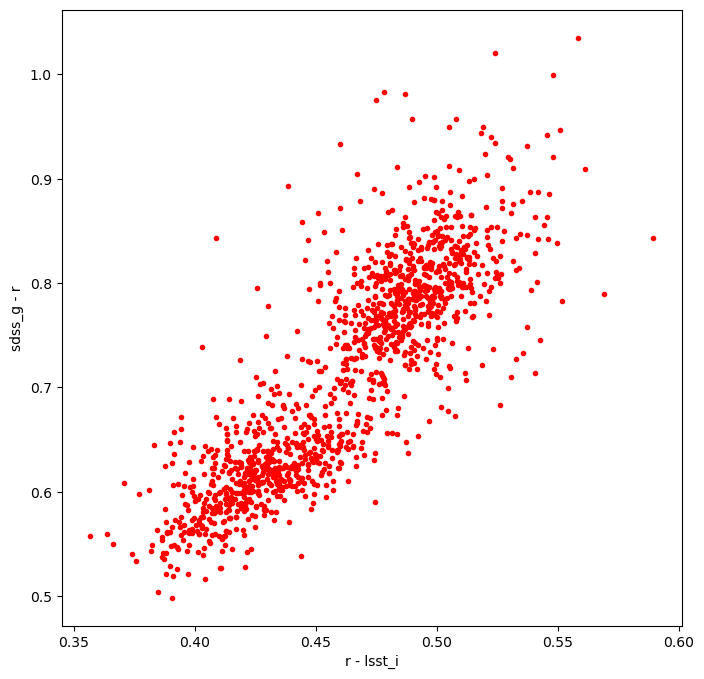

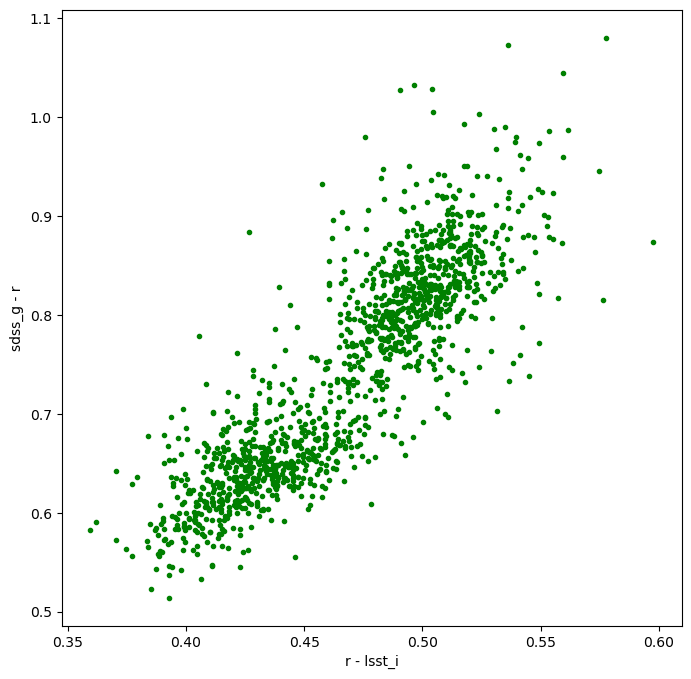

In [20]:
# Plot some color-color combinations
c1 = 'lsst_g'  #g-r
cc1 = 'sdss_g'
c2 = 'lsst_i'  #i-r .. we'll flip so it's r-i
cc2 = 'sdss_i'

fig = plt.figure(figsize=(8,8)) 

smass_keys = sorted(list(smass.keys()))
for i, k in enumerate(smass_keys):
    plt.plot(-colors[k][c2], colors[k][c1], linestyle='', marker='.', color='r', label=k)
plt.xlabel(f"{refband_name} - {c2}")
plt.ylabel(f"{cc1} - {refband_name}")
#plt.legend(loc=(1.01, 0.0))

fig = plt.figure(figsize=(8,8)) 
for i, k in enumerate(smass_keys):
    plt.plot(-colors[k][cc2], colors[k][cc1], linestyle='', marker='.', color='g')
plt.xlabel(f"{refband_name} - {c2}")
plt.ylabel(f"{cc1} - {refband_name}")

Text(0, 0.5, 'sdss_g - r')

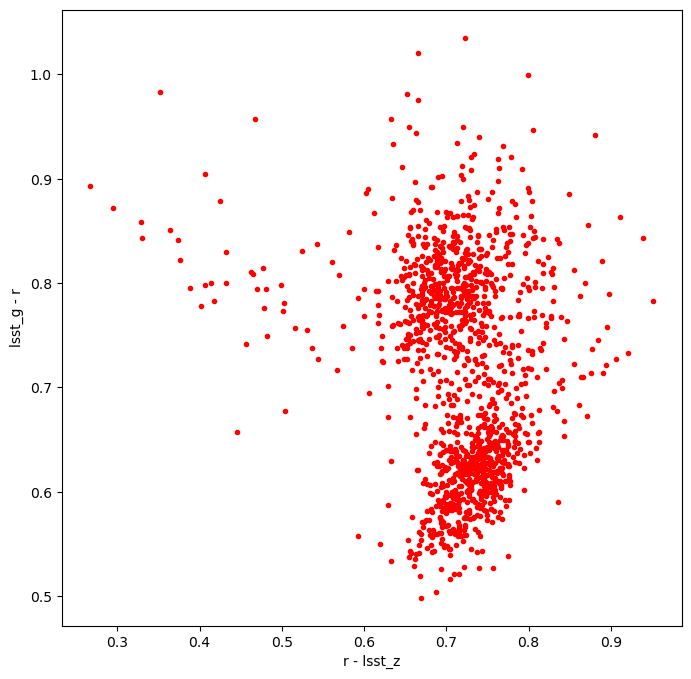

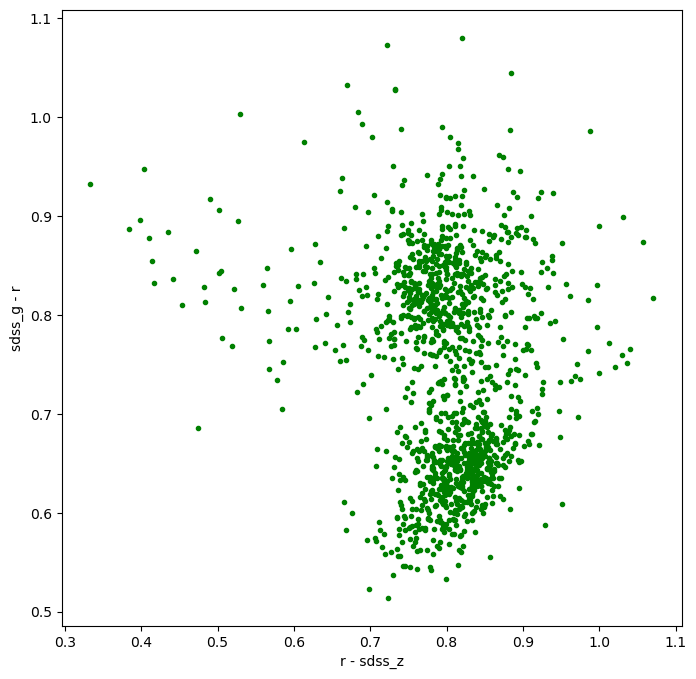

In [21]:
# Plot some color-color combinations
c1 = 'lsst_g'  #g-r
cc1 = 'sdss_g'
c2 = 'lsst_z'  #z-r .. we'll flip so it's r-z
cc2 = 'sdss_z'

fig = plt.figure(figsize=(8,8)) 

smass_keys = sorted(list(smass.keys()))
for i, k in enumerate(smass_keys):
    plt.plot(-colors[k][c2], colors[k][c1], linestyle='', marker='.', color='r', label=k)
plt.xlabel(f"{refband_name} - {c2}")
plt.ylabel(f"{c1} - {refband_name}")
#plt.legend(loc=(1.01, 0.0))

fig = plt.figure(figsize=(8,8)) 
for i, k in enumerate(smass_keys):
    plt.plot(-colors[k][cc2], colors[k][cc1], linestyle='', marker='.', color='g')
plt.xlabel(f"{refband_name} - {cc2}")
plt.ylabel(f"{cc1} - {refband_name}")

Text(0.5, 1.0, 'SDSS SMASSII synthetic colors')

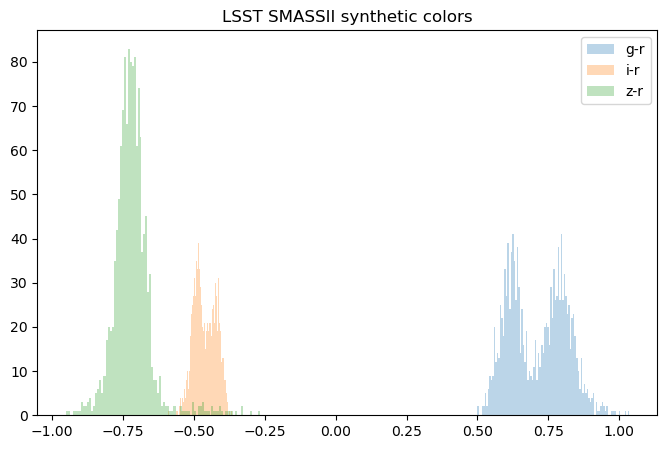

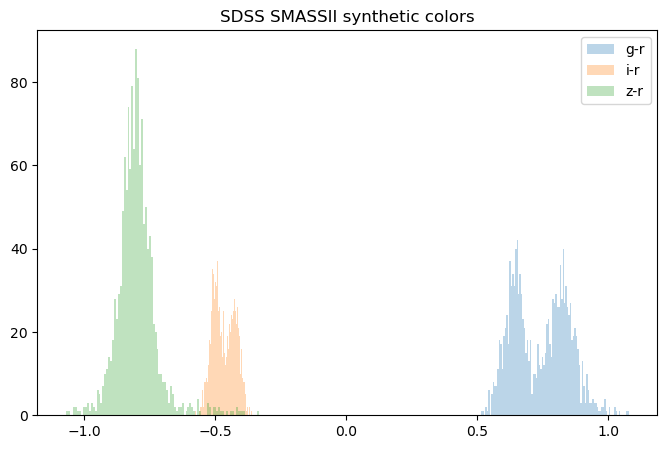

In [22]:
plt.figure(figsize=(8,5))
for f in 'giz':
    plt.hist(df.loc[f'lsst_{f}'], bins=100, alpha=0.3, label=f'{f}-r')
plt.legend()
plt.title('LSST SMASSII synthetic colors')

plt.figure(figsize=(8,5))
for f in 'giz':
    plt.hist(df.loc[f'sdss_{f}'], bins=100, alpha=0.3, label=f'{f}-r')
plt.legend()
plt.title('SDSS SMASSII synthetic colors')

The bimodal distributions in g-r and r-i can be helpful in distinguishing very rough taxonomic classifications. These classifications are correlated with albedo distributions, and can be helpful in constraining size estimates.
See Ivezic & Ivezic 2021 https://www.sciencedirect.com/science/article/abs/pii/S0019103520305832 for an example.

In [23]:
# bonus points - get the taxonomic classifications associated with the SMASS objects 
# and color-code the points in the color-color plots with this information 